In [15]:
!pip install tf_agents

ERROR: Exception:
Traceback (most recent call last):
  File "c:\program files\python36\lib\site-packages\pip\_internal\cli\base_command.py", line 186, in _main
    status = self.run(options, args)
  File "c:\program files\python36\lib\site-packages\pip\_internal\commands\install.py", line 258, in run
    isolated_mode=options.isolated_mode,
  File "c:\program files\python36\lib\site-packages\pip\_internal\commands\install.py", line 604, in decide_user_install
    if site_packages_writable(root=root_path, isolated=isolated_mode):
  File "c:\program files\python36\lib\site-packages\pip\_internal\commands\install.py", line 549, in site_packages_writable
    test_writable_dir(d) for d in set(get_lib_location_guesses(**kwargs))
  File "c:\program files\python36\lib\site-packages\pip\_internal\commands\install.py", line 549, in <genexpr>
    test_writable_dir(d) for d in set(get_lib_location_guesses(**kwargs))
  File "c:\program files\python36\lib\site-packages\pip\_internal\utils\filesystem

In [16]:
from __future__ import absolute_import, division, print_function

# Packages to support visualization
import base64
import imageio
import IPython
import PIL.Image
import pyvirtualdisplay
import matplotlib
import matplotlib.pyplot as plt

# Packages to support model training
import numpy as np
import tensorflow as tf
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.agents.ddpg import actor_network
from tf_agents.agents.ddpg import critic_network
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

In [17]:
# Declare model constants
num_iterations = 10000
initial_collect_steps = 1000
collect_steps_per_iteration = 1  
replay_buffer_max_length = 100000  
batch_size = 64
learning_rate = 1e-3  
log_interval = 200  
num_eval_episodes = 10  
eval_interval = 1000

In [18]:
# Initialize environment
env_name = 'Pendulum-v0'
env = suite_gym.load(env_name)
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Display environment dimensions
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Reward Spec:')
print(env.time_step_spec().reward)
print('Action Spec:')
print(env.action_spec())
time_step = env.reset()
print('Time step:')
print(time_step)

Observation Spec:
BoundedArraySpec(shape=(3,), dtype=dtype('float32'), name='observation', minimum=[-1. -1. -8.], maximum=[1. 1. 8.])
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(1,), dtype=dtype('float32'), name='action', minimum=-2.0, maximum=2.0)
Time step:
TimeStep(step_type=array(0), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([0.8139067 , 0.58099556, 0.8494987 ], dtype=float32))


In [19]:
# Create the agent's actor and critic networks
act_net = actor_network.ActorNetwork(input_tensor_spec = train_env.observation_spec(),
                                     output_tensor_spec = train_env.action_spec(),
                                     fc_layer_params = (400,300),
                                     activation_fn = tf.keras.activations.relu                 
                                     )

crit_net = critic_network.CriticNetwork(input_tensor_spec = (train_env.observation_spec(), train_env.action_spec()),
                                        observation_fc_layer_params = (400,),
                                        action_fc_layer_params = None,
                                        joint_fc_layer_params = (400,),
                                        activation_fn = tf.keras.activations.relu
                                        )

In [20]:
# Instantiate the agent and supply it with its actor and critic networks
actor_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
critic_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

global_step = tf.Variable(0, trainable=False)
starter_epsilon = 1.0
end_epsilon = 0.5
decay_steps = num_iterations + initial_collect_steps
ou_noise_size = tf.compat.v1.train.polynomial_decay(starter_epsilon,
                                                    train_step_counter,
                                                    decay_steps,
                                                    end_epsilon,
                                                    power=1.0,
                                                    cycle=False)

agent = ddpg_agent.DdpgAgent(time_step_spec = train_env.time_step_spec(),
                             action_spec = train_env.action_spec(),
                             actor_network = act_net,
                             critic_network = crit_net,
                             actor_optimizer = actor_optimizer,
                             critic_optimizer = critic_optimizer, 
                             gamma = 0.99,
                             target_critic_network = None, # Target network = same as primary
                             target_update_tau = 0.1, 
                             ou_stddev = ou_noise_size(), # was 1 
                             ou_damping = 0.25,
                             td_errors_loss_fn = common.element_wise_squared_loss,
                             train_step_counter=train_step_counter
                             )

agent.initialize()

In [21]:
# Declare the function that will measure the training progress of the agent
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [22]:
# Create the replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

In [23]:
# Create the function that performs the action on the environment and adds the data to the replay buffer
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

In [24]:
# Compute performance baseline using random actions
example_environment = tf_py_environment.TFPyEnvironment(suite_gym.load(env_name))
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-1059.8229

In [25]:
# Peform functions required before entering the training loop
collect_data(train_env, random_policy, replay_buffer, steps=100)
agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
print(returns)

[-1158.0808]


In [26]:
# Execute the main training loop
for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}, noise = {2}'.format(step, train_loss, float(np.round(np.array(ou_noise_size()),2))))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic_control.rendering.Viewer object at 0x00000184D2C98940>>
Traceback (most recent call last):
  File "C:\Program Files\Python36\lib\site-packages\gym\envs\classic_control\rendering.py", line 162, in __del__
    self.close()
  File "C:\Program Files\Python36\lib\site-packages\gym\envs\classic_control\rendering.py", line 81, in close
    self.window.close()
  File "C:\Program Files\Python36\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Program Files\Python36\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Program Files\Python36\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: (<weakref at 0x00000184D2E3EE58; to 'Win32Window' at 0x00000184D7375048>,)
step = 200: loss = 8.915691375732422, noise = 0.9900000095367432
step = 400: loss = 11.05178165435791, noise = 

Text(0.5, 0, 'Iterations')

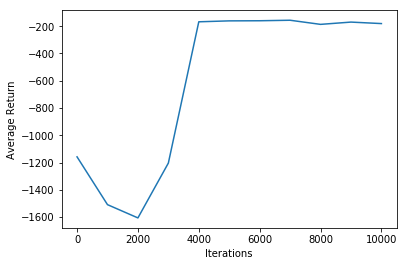

In [27]:
# Visualize the training progress of the agent
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

In [28]:
# Visualize the agent performing its learned behaviour
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = eval_env.step(action_step.action)
            video.append_data(eval_py_env.render())
    return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")
# create_policy_eval_video(random_policy, "random-agent")

W0604 12:04:30.658912 14396 _io.py:418] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
